# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [1]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [2]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [8]:
XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=XDSM_FILE, width='100%', height='500px')

Analysis Group pushed


## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [8]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.07 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019226100000000912 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [9]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

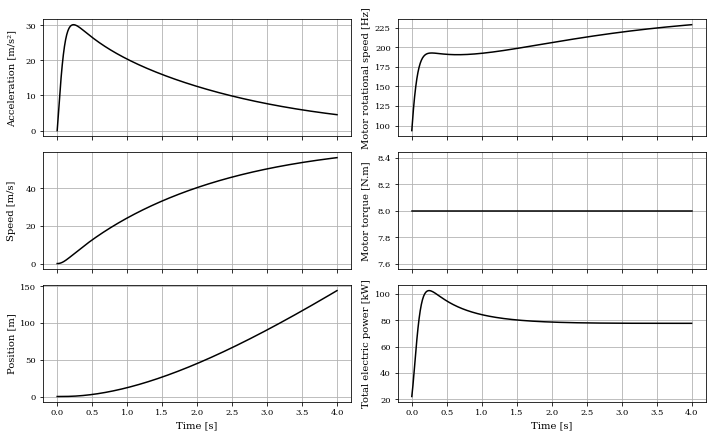

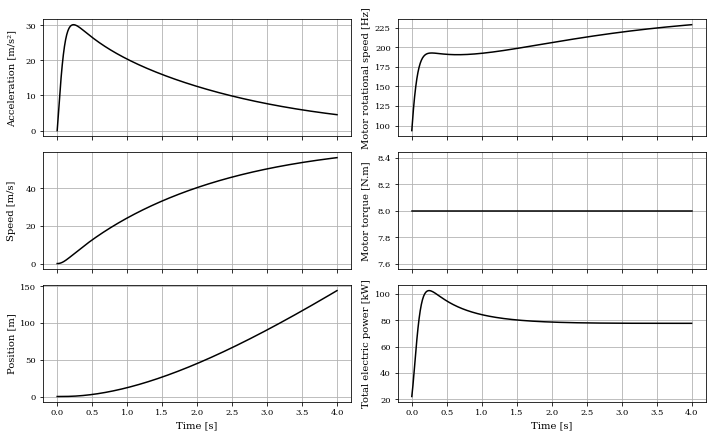

In [10]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [11]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [12]:
api.optimization_viewer(CONFIGURATION_FILE)

In [2]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01874119999999735 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0196645999999987 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02420089999999675 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0193581000000016 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019288599999999434 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018733900000000858 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01862029999999848 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01848409999999845 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0188483999

Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.018966199999997713 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.019318599999998298 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.018525600000000253 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.018836900000000156 seconds.
Simulation interval    : 0.0 - 4.484507215205752 seconds.
Elapsed simulation time: 0.01940519999999779 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.018823399999998713 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.020547099999998153 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.019653999999999172 seconds.
Simulation interval    : 0.0 - 5.5064665734933245 seconds.
Elapsed simulation time: 0.01861220

Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01911839999999998 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01914329999999964 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018608300000000355 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018103299999999933 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.020395099999998223 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.018719100000001987 seconds.
Simulation interval    : 0.0 - 4.361519386597849 seconds.
Elapsed simulation time: 0.01857520000000079 seconds.
Simulation interval    : 0.0 - 2.000000000000836 seconds.
Elapsed simulation time: 0.01938639999999836 seconds.
Simulation interval    : 0.0 - 2.000000000000836 seconds.
Elapsed simulation time: 0.020021999999997

Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.03243319999999983 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.01889759999999896 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.01848020000000261 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.019131299999997964 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.019159699999999447 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.0189218000000011 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.0190601000000008 seconds.
Simulation interval    : 0.0 - 2.5135233653988474 seconds.
Elapsed simulation time: 0.01992710000000031 seconds.
Simulation interval    : 0.0 - 2.4422333662626268 seconds.
Elapsed simulation time: 0.0186497000

Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.01905649999999781 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.019801099999998684 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018577700000001585 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.019190800000000507 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018873700000000326 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.01881079999999713 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.0186793999999999 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018757800000003044 seconds.
Simulation interval    : 0.0 - 2.551213050605885 seconds.
Elapsed simulation time: 0.018432000000000

Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.018535899999999828 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.019325500000000773 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.01858359999999948 seconds.
Simulation interval    : 0.0 - 2.417804757351899 seconds.
Elapsed simulation time: 0.020237800000000306 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.021129099999999568 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.0218619000000011 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.018827800000000394 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.01975180000000165 seconds.
Simulation interval    : 0.0 - 2.4178037573518982 seconds.
Elapsed simulation time: 0.0187080

Simulation interval    : 0.0 - 2.5178020780819432 seconds.
Elapsed simulation time: 0.019388400000000416 seconds.
Simulation interval    : 0.0 - 2.5178020780819432 seconds.
Elapsed simulation time: 0.018666899999999487 seconds.
Simulation interval    : 0.0 - 2.731253686278163 seconds.
Elapsed simulation time: 0.01950390000000013 seconds.
Simulation interval    : 0.0 - 2.564133182712374 seconds.
Elapsed simulation time: 0.019413699999997647 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.018995499999999055 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.019401500000000738 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.01886440000000178 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.019123000000000445 seconds.
Simulation interval    : 0.0 - 2.531805198136849 seconds.
Elapsed simulation time: 0.01963889999

Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.018454899999998275 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01924849999999978 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01842710000000025 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.020070499999999214 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.018561099999999442 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.019004299999998864 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.018877700000000885 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01871359999999811 seconds.
Simulation interval    : 0.0 - 2.5515613236386656 seconds.
Elapsed simulation time: 0.01857

Simulation interval    : 0.0 - 2.5650690443048805 seconds.
Elapsed simulation time: 0.019250900000002957 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018803200000000686 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.019738000000003808 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.01985700000000179 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.019080800000004672 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018903799999996806 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018750300000000664 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.02213599999999616 seconds.
Simulation interval    : 0.0 - 2.558618016560426 seconds.
Elapsed simulation time: 0.018497500000

Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01920870000000008 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01993840000000091 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01943769999999745 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.018803800000000592 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.02090599999999654 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.02093359999999933 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01944549999999623 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.01876490000000075 seconds.
Simulation interval    : 0.0 - 2.5728586843682426 seconds.
Elapsed simulation time: 0.020282999

Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.020150899999997307 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.018822799999995254 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.019891900000004625 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.018927000000005023 seconds.
Simulation interval    : 0.0 - 2.6638249215775334 seconds.
Elapsed simulation time: 0.020164600000001087 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.019180699999999717 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.019303799999995874 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.02093460000000391 seconds.
Simulation interval    : 0.0 - 2.6638239215775332 seconds.
Elapsed simulation time: 0.019

Simulation interval    : 0.0 - 2.748714975379822 seconds.
Elapsed simulation time: 0.018682900000001723 seconds.
Simulation interval    : 0.0 - 2.748714975379822 seconds.
Elapsed simulation time: 0.01964410000000072 seconds.
Simulation interval    : 0.0 - 2.8813460504341872 seconds.
Elapsed simulation time: 0.0196456999999981 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.019118599999998764 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.01934339999999679 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.020318400000000736 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.019385900000003176 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.01910649999999947 seconds.
Simulation interval    : 0.0 - 2.761978082885258 seconds.
Elapsed simulation time: 0.019268799999998

Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01953900000000175 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01872410000000002 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.020511200000001395 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01906380000000496 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.020495000000003927 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.019805099999999243 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.01906370000000379 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.019536899999998525 seconds.
Simulation interval    : 0.0 - 2.7788658565091575 seconds.
Elapsed simulation time: 0.019007

Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.019574200000000985 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.019301599999998587 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.01918300000000528 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.01985360000000469 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.019947699999995905 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.020211800000005553 seconds.
Simulation interval    : 0.0 - 2.781056017557861 seconds.
Elapsed simulation time: 0.019865000000002908 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.019260600000002626 seconds.
Simulation interval    : 0.0 - 2.7810550175578608 seconds.
Elapsed simulation time: 0.01873

Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.018220999999996934 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.019424199999996006 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.018844799999996553 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.020835699999999235 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.019592199999998172 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.01928829999999948 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.01976009999999917 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.019000599999998258 seconds.
Simulation interval    : 0.0 - 2.781067132234056 seconds.
Elapsed simulation time: 0.0226601999999

Simulation interval    : 0.0 - 2.7769318782630785 seconds.
Elapsed simulation time: 0.01989489999999705 seconds.
Simulation interval    : 0.0 - 2.7805791559143986 seconds.
Elapsed simulation time: 0.01838390000000345 seconds.
Simulation interval    : 0.0 - 2.781002331718662 seconds.
Elapsed simulation time: 0.01969530000000219 seconds.
Simulation interval    : 0.0 - 2.781059801178419 seconds.
Elapsed simulation time: 0.01885629999999594 seconds.
Simulation interval    : 0.0 - 2.7810677172569402 seconds.
Elapsed simulation time: 0.02091490000000107 seconds.
Simulation interval    : 0.0 - 2.7810688091145153 seconds.
Elapsed simulation time: 0.01882420000000451 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.019993900000002895 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.020389399999999114 seconds.
Simulation interval    : 0.0 - 2.781068954807252 seconds.
Elapsed simulation time: 0.0195761000000

Simulation interval    : 0.0 - 2.7810718526869924 seconds.
Elapsed simulation time: 0.02087429999999557 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.037875200000001996 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.022210699999995143 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019656499999996413 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018945500000000948 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.020315300000000036 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.018876299999995183 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019741600000003245 seconds.
Simulation interval    : 0.0 - 2.7810703216723303 seconds.
Elapsed simulation time: 0.019

Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.019499299999999664 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.018768999999998925 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01950750000000312 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.0190389000000053 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.018749299999996083 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.019856099999998378 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.019041999999998893 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.019264899999996032 seconds.
Simulation interval    : 0.0 - 2.808611159033979 seconds.
Elapsed simulation time: 0.01871919999999

Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.01937110000000075 seconds.
Simulation interval    : 0.0 - 2.8833883881840356 seconds.
Elapsed simulation time: 0.02147830000000539 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.019218799999997316 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.02096979999999604 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.020787499999997294 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.019135800000000813 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.019266199999997013 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.0194230000000033 seconds.
Simulation interval    : 0.0 - 2.8833873881840355 seconds.
Elapsed simulation time: 0.0189902

Simulation interval    : 0.0 - 2.7452357727141457 seconds.
Elapsed simulation time: 0.01859749999999849 seconds.
Simulation interval    : 0.0 - 2.7612337044030784 seconds.
Elapsed simulation time: 0.01967870000000005 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.01931910000000414 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.02073819999999671 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.018879700000006494 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.018641999999999825 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.019843899999997916 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.02068469999999678 seconds.
Simulation interval    : 0.0 - 2.7650844356583573 seconds.
Elapsed simulation time: 0.0222845

Simulation interval    : 0.0 - 2.765067950615962 seconds.
Elapsed simulation time: 0.019422599999998624 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.019512100000000032 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.019381700000003832 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.019078900000003784 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.01935449999999861 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.020256199999998614 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.021482599999998797 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.020327500000000498 seconds.
Simulation interval    : 0.0 - 2.765066950615962 seconds.
Elapsed simulation time: 0.019924099999

Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.019675600000006455 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.019647999999996557 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.01919240000000144 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.023888200000001802 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.019249600000001976 seconds.
Simulation interval    : 0.0 - 2.7650431599188874 seconds.
Elapsed simulation time: 0.018754999999998745 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.019450800000001323 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.021000899999997102 seconds.
Simulation interval    : 0.0 - 2.758832633445728 seconds.
Elapsed simulation time: 0.019328

Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019478700000000515 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.021700200000005054 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.020345399999996516 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.01884290000000277 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.01897650000000084 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019559000000000992 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.01947189999999921 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.019286099999995088 seconds.
Simulation interval    : 0.0 - 2.7698476614072467 seconds.
Elapsed simulation time: 0.01894

Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019599700000000553 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.018729900000003852 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019117999999998858 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019262400000002344 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019778699999996263 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019971200000000522 seconds.
Simulation interval    : 0.0 - 2.781462212256408 seconds.
Elapsed simulation time: 0.018796700000002886 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.02509109999999737 seconds.
Simulation interval    : 0.0 - 2.781461212256408 seconds.
Elapsed simulation time: 0.019049100000

Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.01937149999999832 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.03367910000000052 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.01911639999999437 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.019626000000002364 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.018944499999996367 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.019780900000000656 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.018940700000001698 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.019472300000003884 seconds.
Simulation interval    : 0.0 - 2.7816854692259363 seconds.
Elapsed simulation time: 0.01977

Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.01926480000000197 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.018881600000000276 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.019552000000004455 seconds.
Simulation interval    : 0.0 - 2.8890955485013317 seconds.
Elapsed simulation time: 0.01928709999999967 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.019023099999998294 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.01942700000000741 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.018585200000003965 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.019274800000005143 seconds.
Simulation interval    : 0.0 - 2.8890945485013324 seconds.
Elapsed simulation time: 0.01937

Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018341300000003002 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.022372300000000678 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.022378200000005677 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.019533899999998994 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.024419199999996977 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.018801899999999705 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.019192899999993074 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.01884330000000034 seconds.
Simulation interval    : 0.0 - 2.876149693628259 seconds.
Elapsed simulation time: 0.019719800000

Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.020115699999990966 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.0188868000000042 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.01992280000000335 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.018892300000004525 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.01943769999999745 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.01842150000000231 seconds.
Simulation interval    : 0.0 - 2.889207081499052 seconds.
Elapsed simulation time: 0.018692900000004897 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.019286099999987982 seconds.
Simulation interval    : 0.0 - 2.8940112865696457 seconds.
Elapsed simulation time: 0.02242139999999

Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.019139299999991977 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.020632899999995402 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.018781500000002893 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.019416700000007836 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.0193812000000122 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.018649899999999775 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.01885290000001305 seconds.
Simulation interval    : 0.0 - 2.905301807120036 seconds.
Elapsed simulation time: 0.018904399999996713 seconds.
Simulation interval    : 0.0 - 2.8961505336676683 seconds.
Elapsed simulation time: 0.0212305999999

Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.022739000000001397 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.019386999999994714 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.018951000000001272 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.01885850000000744 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.018843799999999078 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.020054700000002867 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.019080799999997566 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.019986199999991072 seconds.
Simulation interval    : 0.0 - 2.889895052789968 seconds.
Elapsed simulation time: 0.019017800000

Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.019299499999988257 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.01928999999999803 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.019473299999987148 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.02004940000000488 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.018582899999998403 seconds.
Simulation interval    : 0.0 - 2.894732911602602 seconds.
Elapsed simulation time: 0.02510469999999998 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.026483900000002336 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.02110009999999818 seconds.
Simulation interval    : 0.0 - 2.894731911602602 seconds.
Elapsed simulation time: 0.020666800000000

Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.020635299999995027 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.019835700000001566 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.019717600000006996 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.019852000000000203 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.019756799999996133 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.020708900000002473 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.018863199999998415 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.026925700000006714 seconds.
Simulation interval    : 0.0 - 2.891633428251247 seconds.
Elapsed simulation time: 0.02652430000

INFO    : Computation finished after 59.09 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.162813680913776
            Iterations: 83
            Function evaluations: 238
            Gradient evaluations: 83
Optimization Complete
-----------------------------------


Let's save these results:

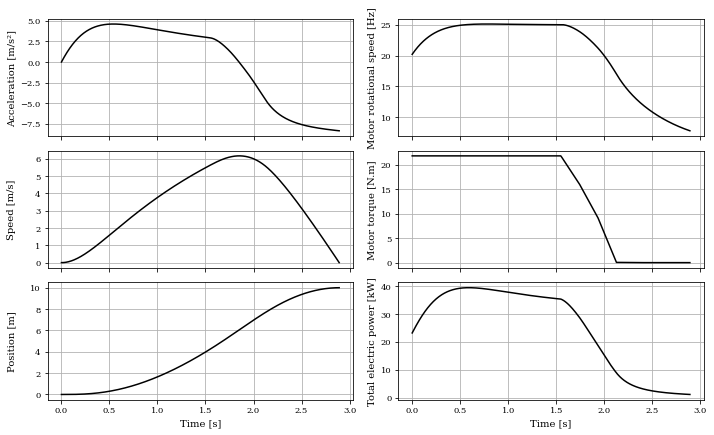

In [3]:
fig = plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [4]:
fig.savefig("co-design_openmdao.pdf")

In [5]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [6]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [7]:
api.variable_viewer(OUTPUT_FILE)

In [18]:
# Checking the complete model
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].